# Oblique Schmidt Method
Implement extrapolator that uses oblique schmidt method

In [42]:
import glob
import os
import copy

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.coordinates
import yt
import sunpy.sun.constants
import sunpy.map
import sunpy.net
import sunpy.time
import sunpy.coordinates
from sunpy.visualization import wcsaxes_compat
import solarbextrapolation.extrapolators
import synthesizAR

%matplotlib inline

In [ ]:
result_aia = sunpy.net.Fido.search(
    sunpy.net.attrs.Time(sunpy.time.TimeRange('2017/08/22 18:15',1*u.min)),
    sunpy.net.attrs.Instrument('AIA'),
    sunpy.net.attrs.Wavelength(171*u.angstrom)
)

In [ ]:
result_hmi = sunpy.net.Fido.search(
    sunpy.net.attrs.Time(sunpy.time.TimeRange('2017/08/22 18:15',1*u.min)),
    sunpy.net.attrs.Instrument('HMI') & sunpy.net.attrs.vso.Physobs('LOS_magnetic_field'),
)

In [ ]:
aia_files = sunpy.net.Fido.fetch(result_aia)

In [2]:
aia_files = ['/Users/willbarnes/sunpy/data/aia_lev1_171a_2017_08_22t18_15_57_35z_image_lev1.fits']

In [ ]:
hmi_files = sunpy.net.Fido.fetch(result_hmi)

In [3]:
hmi_files = ['/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_22_18_16_30_tai_magnetogram.fits']

In [95]:
m = sunpy.map.Map(hmi_files[0])

In [5]:
lc = (150*u.arcsec,-225*u.arcsec)
rc = (725*u.arcsec,350*u.arcsec)
bottom_left = astropy.coordinates.SkyCoord(*lc,frame=m.coordinate_frame)
top_right = astropy.coordinates.SkyCoord(*rc,frame=m.coordinate_frame)

In [6]:
m_zoom = m.rotate().submap(bottom_left,top_right)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


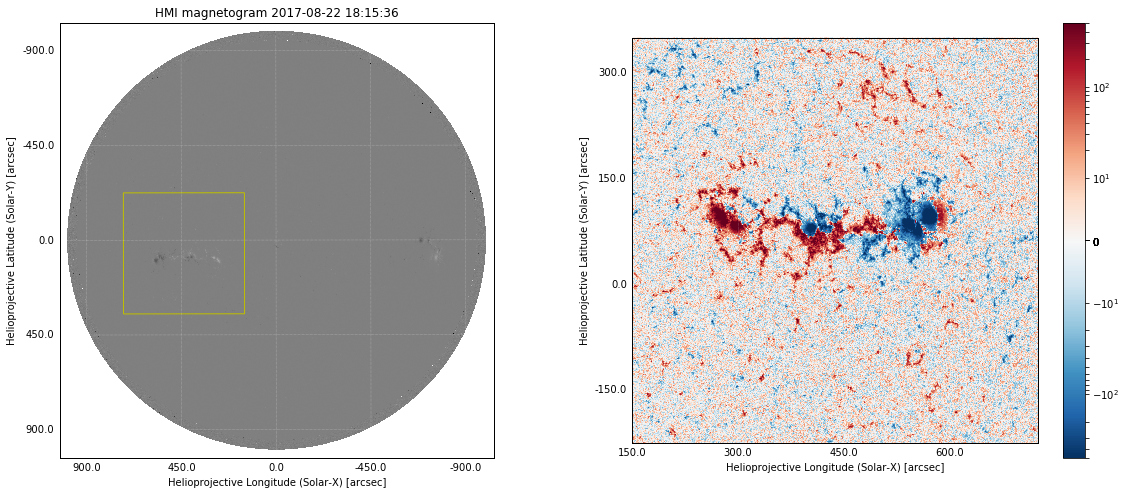

In [7]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121,projection=m)
m.plot(axes=ax)
m.draw_rectangle(bottom_left,rc[0]-lc[0],rc[1]-lc[1],color='y')
ax = fig.add_subplot(122,projection=m_zoom)
im = m_zoom.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
fig.colorbar(im)

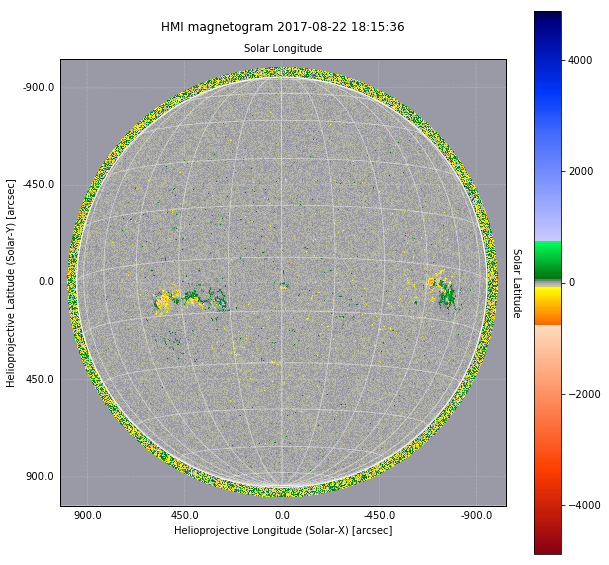

In [105]:
plt.figure(figsize=(10,10))
foo = sunpy.map.Map(np.where(np.isnan(m.data),0,m.data),m.meta)
foo.plot(cmap='hmimag')
foo.draw_limb()
foo.draw_grid()
plt.colorbar()

## Classical Schmidt Method

In [64]:
zshape = 100
zrange = u.Quantity([0*u.arcsec,max(rc[0]-lc[0],rc[1]-lc[1])])

In [65]:
classical_field = synthesizAR.Skeleton(hmi_fits_file=hmi_files[0],crop=(lc,rc),resample=[100,100]*u.pixel)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [66]:
classical_field.extrapolate_field(zshape=zshape,zrange=zrange,use_numba_for_extrapolation=True)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-ro

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [67]:
classical_field.extract_streamlines(500,mask_threshold=0.15,safety=1.5)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:64: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:65: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2018-01-31 15:08:10,506 AMRKDTree rebuilt, Final Volume: 6.682560e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 660.52it/s]
yt : [INFO     ] 2018-01-31 15:08:11,895 AMRKDTree rebuilt, Final Volume: 6.682560e+31
Streamlining: 100%|██████████| 172/172 [00:00<00:00, 642.30it/s]
yt : [INFO     ] 2018-01-31 15:08:12,592 AMRKDTree rebuilt, Final Volume: 6.682560e+31
Streamlinin

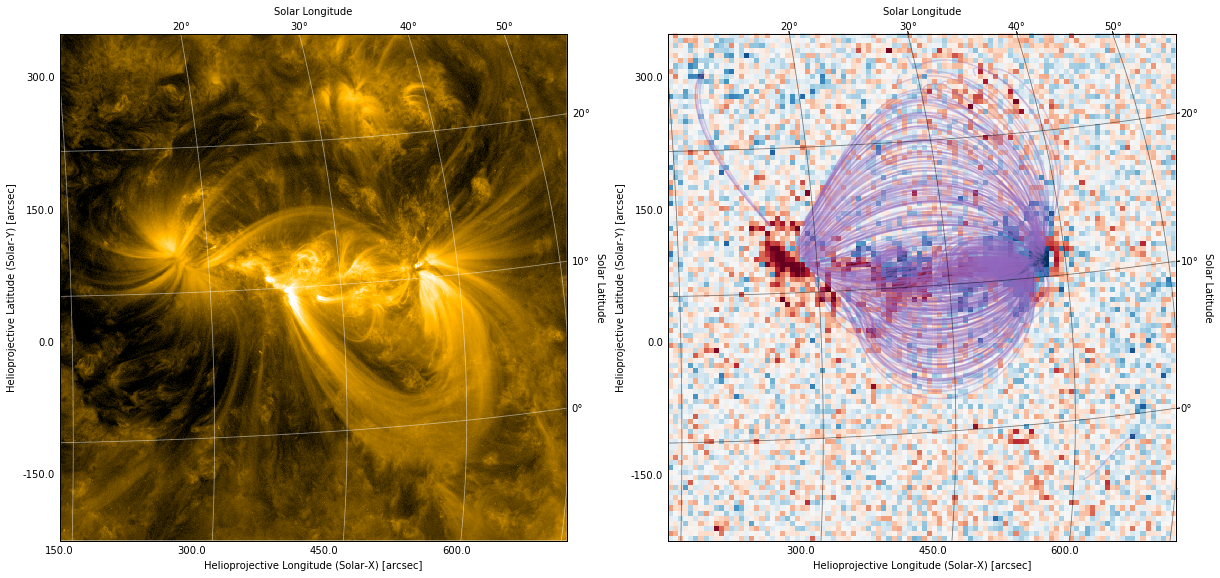

In [71]:
fig = plt.figure(figsize=(20,10))
aia_m = sunpy.map.Map(aia_files[-1])
aia_m = aia_m.submap(astropy.coordinates.SkyCoord(*lc,frame=aia_m.coordinate_frame),
                     astropy.coordinates.SkyCoord(*rc,frame=aia_m.coordinate_frame))
ax = fig.add_subplot(121,projection=aia_m)
aia_m.plot(axes=ax,title=False,norm=matplotlib.colors.LogNorm(vmin=50,vmax=5e3))
aia_m.draw_grid(axes=ax,grid_spacing=10*u.deg)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax = fig.add_subplot(122,projection=classical_field.hmi_map)
im = classical_field.hmi_map.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
classical_field.hmi_map.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k')
for stream, _ in classical_field.streamlines:
    ax.plot(classical_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            classical_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.3,color='C4',transform=ax.get_transform('world'))

Because the AR is far from disk center, the classical Schmidt approximation does not do well. A cursory comparison reveals that the field extrapolation at the right does not capture the correct orientation of the loops.

## Oblique Schmidt Method
Section 3 of Sakurai (1982) outlines the oblique Schmidt method. The potential now is given by,

$$
\phi(\vec{r}) = \int\mathrm{d}S\,B_{\ell}(\vec{r}^{'})G_{\ell}(\vec{r},\vec{r}^{'}) \approx \sum_{ij}B_{\ell}(r_{ij})G_{\ell}(r,r_{ij})S_{ij},
$$

where $B_l$ is the observed field at the boundary which satisfies the condition 

$$
-\hat{\ell}\cdot\nabla\phi=B_{\ell},
$$
$\hat{\ell}$ is the vector from the AR to observer and the Green's function for the problem can be written as,

$$
G_{\ell}(\vec{r},\vec{r}^{'}) = \frac{1}{2\pi}\left(\frac{\hat{n}\cdot\hat{\ell}}{R} + \frac{\hat{\mu}\cdot\vec{R}}{R(R+\hat{\ell}\cdot\vec{R})}\right)
$$

where $\hat{n}$ is the vector perpendicular to the surface of the Sun, $\vec{R}=\vec{r}-\vec{r}^{'}$ and $\hat{\mu}=\hat{\ell}\times(\hat{n}\times\hat{\ell})$

We can treat $\hat{n}=\hat{z}$ and work within a local cartesian coordinate system. The problem then is to find $\hat{\ell}$, the LOS vector to the observer, in our new rotated coordinate system. 

Our new rotated coordinate system can be described as two rotations from a heliocentric equatorial (HEEQ) cartesian coordinate system: first by $\Phi$ and then by $\Theta$. $(\Phi,\Theta)$ are the heliographic Stonyhurst longitude and latitude of the center of our AR. 

Note that $\hat{\ell}=\hat{z}$ in the HCC frame. To easily rotate the frame, we need to convert $\hat{\ell}$ to HEEQ. From Eq. 21 of Thompson (2006), 

$$
\hat{\ell} = (\cos{B_0},0,\sin{B_0}),
$$

where $B_0$ is the heliographic latitude of the observer. Now apply the rotation matrices $\mathbf{R}_z(-\Phi)$ and $\mathbf{R}_y(\Theta)$, where the sign of the angle is negative because we are rotating into the new frame and $\Theta>0$ because is measured from the $x$-axis (as opposed to the usual convention for spherical coordinates to measure from the z-axis). Thus, the final expression for our unit LOS vector in our rotated frame is,

$$
\hat{\ell} = \begin{bmatrix}\cos\Phi & \sin\Phi & 0 \\
                            -\sin\Phi & \cos\Phi & 0 \\
                            0 & 0 & 1
             \end{bmatrix}
             \begin{bmatrix}\cos\Theta & 0 & \sin\Theta \\
                            0 & 1 & 0 \\
                            -\sin\Theta & 0 & \cos\Theta
             \end{bmatrix}
             \begin{bmatrix}\cos B_0 \\ 0 \\ \sin B_0
             \end{bmatrix}
$$

To do this, we'll create a copy of our already-cropped and down-sampled map from our field.

In [72]:
B_l = copy.copy(classical_field.hmi_map)

Next, we'll find $(\Phi,\Theta)$ by transforming the center of our map to HGS

In [73]:
center_hgs = B_l.center.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst)
Phi = center_hgs.data.lon.to(u.radian)
Theta = center_hgs.data.lat.to(u.radian)
B0 = B_l.heliographic_latitude.to(u.radian)

In [74]:
print(Phi)
print(Theta)

0.488892rad
0.176331rad


Now we need to calculate $\ell$ in rotated coordinate system using the formula above. 

In [75]:
def cartesian_rotation_matrix(angle_z, angle_y, angle_x):
    R_z = np.array([[np.cos(angle_z), -np.sin(angle_z), 0],
                    [np.sin(angle_z), np.cos(angle_z), 0],
                    [0, 0, 1]])
    R_y = np.array([[np.cos(angle_y), 0, np.sin(angle_y)],
                    [0, 1, 0],
                    [-np.sin(angle_y), 0, np.cos(angle_y)]])
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(angle_x), -np.sin(angle_x)],
                    [0, np.sin(angle_x), np.cos(angle_x)]])
    return R_z @ R_y @ R_x

def rotation_z(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                    [np.sin(angle), np.cos(angle), 0],
                    [0, 0, 1]])

def rotation_y(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)],
                    [0, 1, 0],
                    [-np.sin(angle), 0, np.cos(angle)]])

def rotation_x(angle):
    return np.array([[1, 0, 0],
                    [0, np.cos(angle), -np.sin(angle)],
                    [0, np.sin(angle), np.cos(angle)]])
    

def hcc_to_heeq(x_hcc,y_hcc,z_hcc,B0):
    x_heeq = z_hcc*np.cos(B0) - y_hcc*np.sin(B0)
    y_heeq = x_hcc
    z_heeq = z_hcc*np.sin(B0) + y_hcc*np.cos(B0)
    return x_heeq,y_heeq,z_heeq

def heeq_to_hcc(x_heeq,y_heeq,z_heeq,B0):
    x_hcc = y_heeq
    y_hcc = z_heeq*np.cos(B0) - x_heeq*np.sin(B0)
    z_hcc = z_heeq*np.sin(B0) + x_heeq*np.cos(B0)
    return x_hcc,y_hcc,z_hcc

In [76]:
l_hat = rotation_z(-Phi) @ rotation_y(Theta) @ np.array(hcc_to_heeq(0,0,1,B0))

Finally, note that in our new local cartesian frame, $(x,y,z)\to(z,x,y)$ such that $z$ is out of the page along the surface normal.

In [ ]:
l_hat = np.roll(l_hat,-1)

Now, let's define a few of the quantities we'll need to calculate $\phi$ and $G_{\ell}$

In [ ]:
n_hat = np.array([0,0,1])
l_dot_n = np.dot(l_hat,n_hat)

In [ ]:
blc = B_l.bottom_left_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
trc = B_l.top_right_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data

In [ ]:
dx = (trc.lon - blc.lon).to(u.radian).value*blc.distance.to(u.m)/B_l.dimensions.x
dy = (trc.lat - blc.lat).to(u.radian).value*blc.distance.to(u.m)/B_l.dimensions.y
dz = max(dx*B_l.dimensions.x,dy*B_l.dimensions.y)/(zshape*u.pixel)
dipole_depth = -dz.value/np.sqrt(2.*np.pi)

Define the Greens function. This comes from Equation 3.6 of Sakurai (1981)

In [ ]:
def greens_function(x, y, z, x_grid, y_grid, dipole_depth):
    """
    Calculate contribution from boundary to each cell. Note that x,y,z should be in heliocentric coordinates
    """
    Rx = x - x_grid 
    Ry = y - y_grid 
    Rz = z - dipole_depth
    R_mag = np.sqrt(Rx**2 + Ry**2 + Rz**2)
    l_dot_R = l_hat[0]*Rx + l_hat[1]*Ry + l_hat[2]*Rz
    mu_dot_R = Rx*n_hat[0] + Ry*n_hat[1] + Rz*n_hat[2] - l_dot_R*l_dot_n
    term1 = l_dot_n/R_mag
    term2 = mu_dot_R/(R_mag*(R_mag + l_dot_R))
    return 1./(2.*np.pi)*(term1 + term2)

Now use the Greens function to calculate $\phi$

In [ ]:
s_ij = (dx*dy).value
boundary_field = (B_l.data*u.Gauss).to(u.Tesla).value
phi = np.empty((int(B_l.dimensions.y.value),int(B_l.dimensions.x.value),zshape))

In [ ]:
yp,xp = np.indices((int(B_l.dimensions.x.value),int(B_l.dimensions.y.value)))
x_grid = xp*dx.value
y_grid = yp*dy.value

In [ ]:
for i in range(int(B_l.dimensions.x.value)):
    for j in range(int(B_l.dimensions.y.value)):
        for k in range(zshape):
            x = i*dx.value
            y = j*dy.value
            z = k*dz.value
            green = greens_function(x, y, z, x_grid,y_grid,dipole_depth)
            phi[j,i,k] = (boundary_field*green*s_ij).sum()

Now calculate $\vec{B}$,

$$
\vec{B} = -\nabla\phi
$$

and use a 5-point stencil to compute the gradient numerically,

$$
\frac{\partial\phi}{\partial x_i} \approx \frac{
-\phi(x_i+2\Delta x_i) + 8\phi(x_i+\Delta x_i) - 8\phi(x_i-\Delta x_i) + \phi(x_i - 2\Delta x_i)
}{12\Delta x_i}
$$

In [ ]:
Bfield = np.zeros(phi.shape+(3,))
Bfield[2:-2, 2:-2, 2:-2, 0] = -(phi[:-4, 2:-2, 2:-2] - 8.*phi[1:-3, 2:-2, 2:-2] + 8.*phi[3:-1, 2:-2, 2:-2]
                                - phi[4:, 2:-2, 2:-2])/12./dx
Bfield[2:-2, 2:-2, 2:-2, 1] = -(phi[2:-2, :-4, 2:-2] - 8.*phi[2:-2, 1:-3, 2:-2] + 8.*phi[2:-2, 3:-1, 2:-2] 
                                - phi[2:-2, 4:, 2:-2])/12./dy
Bfield[2:-2, 2:-2, 2:-2, 2] = -(phi[2:-2, 2:-2, :-4] - 8.*phi[2:-2, 2:-2, 1:-3] + 8.*phi[2:-2, 2:-2, 3:-1]
                                - phi[2:-2, 2:-2, 4:])/12./dz

In [ ]:
for i in range(3):
    for j in [0,1]:
        Bfield[j,:,:,i] = Bfield[2,:,:,i]
        Bfield[:,j,:,i] = Bfield[:,2,:,i]
        Bfield[:,:,j,i] = Bfield[:,:,2,i]
    for j in [-2,-1]:
        Bfield[j,:,:,i] = Bfield[-3,:,:,i]
        Bfield[:,j,:,i] = Bfield[:,-3,:,i]
        Bfield[:,:,j,i] = Bfield[:,:,-3,i]

In [ ]:
def make_yt_dataset(magnetogram, map_3d, zrange):
    data = dict(
                Bx=(np.swapaxes(map_3d[:, :, :, 1], 0, 1), 'T'),
                By=(np.swapaxes(map_3d[:, :, :, 0], 0, 1), 'T'),
                Bz=(np.swapaxes(map_3d[:, :, :, 2], 0, 1), 'T'))
    blc = magnetogram.bottom_left_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
    trc = magnetogram.top_right_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
    dx = (trc.lon - blc.lon).to(u.radian).value*blc.distance.to(u.cm)
    dy = (trc.lat - blc.lat).to(u.radian).value*blc.distance.to(u.cm)
    dz = max(dx,dy)
    # create the bounding box
    bbox = np.array([[-dx.value/2,dx.value/2],
                     [-dy.value/2,dy.value/2],
                     [0,dz.to(u.cm).value]])
    # assemble the dataset
    return yt.load_uniform_grid(data, data['Bx'][0].shape, bbox=bbox, length_unit=yt.units.cm,
                                geometry=('cartesian', ('x', 'y', 'z')))

In [ ]:
oblique_field = synthesizAR.Skeleton()
oblique_field._zrange = zrange
oblique_field.hmi_map = B_l
#fake_3d_field = np.zeros(Bfield.shape)
#fake_3d_field[:,:,:,0] = np.transpose(Bfield[:,:,:,0],axes=[0,1,2])
#fake_3d_field[:,:,:,1] = np.transpose(Bfield[:,:,:,1],axes=[0,1,2])
#fake_3d_field[:,:,:,2] = np.transpose(Bfield[:,:,:,2],axes=[0,1,2])
oblique_field._map_3d = Bfield
oblique_field.extrapolated_3d_field = make_yt_dataset(oblique_field.hmi_map, oblique_field._map_3d,
                                                      oblique_field._zrange)
oblique_field.clipped_hmi_map = oblique_field.hmi_map

In [ ]:
center=(classical_field.extrapolated_3d_field.domain_center
        +np.array([0.1,0,0])*classical_field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(classical_field.extrapolated_3d_field,'x','Bx',
                 origin='lower-right-domain',
                 axes_unit='cm',
                 center=center
                )
p.annotate_streamlines('By','Bz',density=2,plot_args={'color':'w'})
p.set_zlim('Bx',-1e-2,1e-2)
p.set_log('Bx',True,linthresh=1e-3)
p.show()

In [ ]:
center=(oblique_field.extrapolated_3d_field.domain_center
        +np.array([0,0,-0.45])*oblique_field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(oblique_field.extrapolated_3d_field,'z','Bz',
                 origin='lower-right-domain',
                 axes_unit='cm',
                 center=center
                )
p.annotate_streamlines('Bx','By',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-1e-2,1e-2)
#p.set_log('Bz',True,linthresh=1e-3)
p.show()

In [ ]:
oblique_field.extract_streamlines(500,get_seed_points=get_seed_points,
                                  loop_length_range=[1e9,5e10]*u.cm,direction=1)

In [ ]:
xmesh,ymesh = np.meshgrid(
    np.linspace(oblique_field.extrapolated_3d_field.domain_left_edge[0],
                oblique_field.extrapolated_3d_field.domain_right_edge[0],
                oblique_field.extrapolated_3d_field.domain_dimensions[0]),
    np.linspace(oblique_field.extrapolated_3d_field.domain_left_edge[1],
                oblique_field.extrapolated_3d_field.domain_right_edge[1],
                oblique_field.extrapolated_3d_field.domain_dimensions[1])
)
boundary_interp = scipy.interpolate.interp2d(xmesh,ymesh,oblique_field._map_3d[:,:,0,2])

In [ ]:
boundary_map = m_zoom#oblique_field.hmi_map
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111,projection=aia_m)
#im = aia_m.plot(axes=ax,title=False,norm=matplotlib.colors.LogNorm(vmin=50,vmax=5e3))
#aia_m.draw_grid(axes=ax,grid_spacing=10*u.deg,color='w')
ax = fig.add_subplot(111,projection=boundary_map)
im = boundary_map.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
boundary_map.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k')
ax.grid(alpha=0)
ar_center = B_l.center.transform_to(sunpy.coordinates.frames.Heliocentric(observer=B_l.observer_coordinate)).data
for stream, _ in oblique_field.streamlines[::5]:
    #ax.plot(oblique_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
    #        oblique_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
    #        alpha=0.5,color='r',transform=ax.get_transform('world'))
    stream = np.roll(np.array(stream),1,axis=1)
    loop_rot = rotation_y(-Theta) @ rotation_z(Phi) @ stream.T
    x_hcc,y_hcc,z_hcc = heeq_to_hcc(loop_rot[0,:],loop_rot[1,:],loop_rot[2,:],B0)
    x_hcc = (x_hcc*u.cm).to(u.km) + ar_center.x
    y_hcc = (y_hcc*u.cm).to(u.km) + ar_center.y
    z_hcc = (z_hcc*u.cm).to(u.km) + ar_center.z
    ax.plot_coord((astropy.coordinates.SkyCoord(x=x_hcc,
                                                y=y_hcc,
                                                z=z_hcc,
                                                frame=sunpy.coordinates.frames.Heliocentric,
                                                observer=boundary_map.observer_coordinate)
                   .transform_to(boundary_map.coordinate_frame)),'k-',alpha=0.5)

In [ ]:
lower_left_corner = u.Quantity([-dx*B_l.dimensions.x,-dy*B_l.dimensions.y,0*u.cm])

In [ ]:
foo = cartesian_rotation_matrix(Phi,-Theta,0) @ np.roll(lower_left_corner.value,1)

In [ ]:
bar_x,bar_y,bar_z = heeq_to_hcc(foo[0],foo[1],foo[2],B0)*u.cm

In [ ]:
bar_x += ar_center.x
bar_y += ar_center.y
bar_z += ar_center.z

In [ ]:
astropy.coordinates.SkyCoord(x=bar_x,y=bar_y,z=bar_z,frame=sunpy.coordinates.frames.Heliocentric,
                             observer=B_l.observer_coordinate).transform_to(sunpy.coordinates.frames.Helioprojective)

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection=m_zoom)
m_zoom.plot(axes=ax,)
ax.plot_coord(astropy.coordinates.SkyCoord(300*u.arcsec,0*u.arcsec,frame=m_zoom.coordinate_frame),'bo')
ax.plot_coord((astropy.coordinates.SkyCoord(x=219026.53735276*u.km,
                                            y=0*u.km,
                                            z=660638.61220477*u.km,frame=sunpy.coordinates.frames.Heliocentric,
                                            observer=m_zoom.observer_coordinate)
               .transform_to(m_zoom.coordinate_frame)),
              'r+')

Implement extrapolator in the `solarbextrapolation` framework

In [78]:
class ObliqueExtrapolator(object):
    
    @u.quantity_input
    def __init__(self,magnetogram, width_z: u.cm, zshape: u.pixel):
        self.magnetogram = magnetogram
        self.zshape = zshape
        self.width_z = width_z
        self.center = magnetogram.center.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst)
        self.xshape = self.magnetogram.dimensions.x
        self.yshape = self.magnetogram.dimensions.y
        blc = magnetogram.bottom_left_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
        trc = magnetogram.top_right_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
        self.dx = (trc.lon - blc.lon).to(u.radian).value*blc.distance.to(u.m)/self.xshape
        self.dy = (trc.lat - blc.lat).to(u.radian).value*blc.distance.to(u.m)/self.yshape
        self.dz = width_z.to(u.m)/self.zshape
        
    def greens_function(self, x, y, z, x_grid, y_grid, z_depth, l_hat, n_hat):
        Rx = x - x_grid 
        Ry = y - y_grid 
        Rz = z - z_depth
        R_mag = np.sqrt(Rx**2 + Ry**2 + Rz**2)
        l_dot_n = np.dot(l_hat,n_hat)
        l_dot_R = l_hat[0]*Rx + l_hat[1]*Ry + l_hat[2]*Rz
        mu_dot_R = Rx*n_hat[0] + Ry*n_hat[1] + Rz*n_hat[2] - l_dot_R*l_dot_n
        term1 = l_dot_n/R_mag
        term2 = mu_dot_R/(R_mag*(R_mag + l_dot_R))
        return 1./(2.*np.pi)*(term1 + term2)

    def calculate_phi(self):
        # Lower Boundary grid
        y_grid,x_grid = np.indices((int(self.xshape.value), int(self.yshape.value)))
        x_grid = x_grid*self.dx.value
        y_grid = y_grid*self.dy.value
        s_ij = (self.dx*self.dy).value
        z_depth = -self.dz/np.sqrt(2.*np.pi)
        boundary_field = (self.magnetogram.data*u.Unit(self.magnetogram.meta['bunit'])).to(u.Tesla).value
        
        ## Calculate a few vectors in our new rotated coordinate system
        # Surface normal unit vector
        n_hat = np.array([0,0,1])
        # LOS unit vector
        l_hat = self.magnetogram.observer_coordinate.transform_to(
                    sunpy.coordinates.frames.Heliocentric(
                        observer=self.magnetogram.observer_coordinate)).data.xyz.value
        l_hat /= np.sqrt((l_hat**2).sum())
        l_hat = self._rotation_z(-self.center.data.lon) @ self._rotation_y(self.center.data.lat) @ np.array(self._hcc_to_heeq(*l_hat))
        l_hat = np.roll(l_hat,-1)
    
        # Calculate phi 
        phi = np.empty((int(self.xshape.value), int(self.yshape.value), int(self.zshape.value)))
        for i in range(int(self.xshape.value)):
            for j in range(int(self.yshape.value)):
                for k in range(int(self.zshape.value)):
                    x = i*self.dx.value
                    y = j*self.dy.value
                    z = k*self.dz.value
                    green = self.greens_function(x, y, z, x_grid, y_grid, z_depth.value, l_hat, n_hat)
                    phi[j,i,k] = (boundary_field*green*s_ij).sum()
                    
        return phi
    
    def calculate_field(self, phi):
        Bfield = np.zeros(phi.shape+(3,))
        # Take gradient--indexed as x,y,z in 4th dimension
        Bfield[2:-2, 2:-2, 2:-2, 0] = -(phi[:-4, 2:-2, 2:-2] - 8.*phi[1:-3, 2:-2, 2:-2] + 8.*phi[3:-1, 2:-2, 2:-2]
                                        - phi[4:, 2:-2, 2:-2])/12./self.dx.value
        Bfield[2:-2, 2:-2, 2:-2, 1] = -(phi[2:-2, :-4, 2:-2] - 8.*phi[2:-2, 1:-3, 2:-2] + 8.*phi[2:-2, 3:-1, 2:-2] 
                                        - phi[2:-2, 4:, 2:-2])/12./self.dy.value
        Bfield[2:-2, 2:-2, 2:-2, 2] = -(phi[2:-2, 2:-2, :-4] - 8.*phi[2:-2, 2:-2, 1:-3] + 8.*phi[2:-2, 2:-2, 3:-1]
                                        - phi[2:-2, 2:-2, 4:])/12./self.dz.value
        # Set boundary conditions
        for i in range(3):
            for j in [0,1]:
                Bfield[j,:,:,i] = Bfield[2,:,:,i]
                Bfield[:,j,:,i] = Bfield[:,2,:,i]
                Bfield[:,:,j,i] = Bfield[:,:,2,i]
            for j in [-2,-1]:
                Bfield[j,:,:,i] = Bfield[-3,:,:,i]
                Bfield[:,j,:,i] = Bfield[:,-3,:,i]
                Bfield[:,:,j,i] = Bfield[:,:,-3,i]
                
        return Bfield
    
    def extrapolate(self,**kwargs):
        phi = self.calculate_phi()
        B = self.calculate_field(phi)
        return B
    
    def convert_to_yt(self,Bfield):
        data = dict(
            Bx=(np.swapaxes(Bfield[:, :, :, 1], 0, 1), 'T'),
            By=(np.swapaxes(Bfield[:, :, :, 0], 0, 1), 'T'),
            Bz=(np.swapaxes(Bfield[:, :, :, 2], 0, 1), 'T'))
        width_x = (self.dx*self.magnetogram.dimensions.x).to(u.cm)
        width_y = (self.dy*self.magnetogram.dimensions.y).to(u.cm)
        width_z = (self.dz*self.zshape).to(u.cm)
        # create the bounding box
        bbox = np.array([[-width_x.value/2,width_x.value/2],
                         [-width_y.value/2,width_y.value/2],
                         [0,width_z.to(u.cm).value]])
        # assemble the dataset
        return yt.load_uniform_grid(data, data['Bx'][0].shape, bbox=bbox, length_unit=yt.units.cm,
                                    geometry=('cartesian', ('x', 'y', 'z')))
    
    @staticmethod
    def trace_fieldlines(ds, boundary_map, number_fieldlines, **kwargs):
        code_length = ds.domain_width/ds.domain_width.value
        seed_points = get_seed_points(ds, boundary_map, number_fieldlines)
        fieldlines = yt.visualization.api.Streamlines(ds,seed_points*code_length,
                                                       xfield='Bx', yfield='By', zfield='Bz',
                                                       get_magnitude=True, direction=1)
        fieldlines.integrate_through_volume()
        fieldlines.clean_streamlines()
        return fieldlines
        
    @staticmethod
    def _rotation_z(angle):
        angle = angle.to(u.radian)
        return np.array([[np.cos(angle), -np.sin(angle), 0],
                         [np.sin(angle), np.cos(angle), 0],
                         [0, 0, 1]])
    
    @staticmethod
    def _rotation_y(angle):
        angle = angle.to(u.radian)
        return np.array([[np.cos(angle), 0, np.sin(angle)],
                        [0, 1, 0],
                        [-np.sin(angle), 0, np.cos(angle)]])
    
    @staticmethod
    def _rotation_x(angle):
        angle = angle.to(u.radian)
        return np.array([[1, 0, 0],
                        [0, np.cos(angle), -np.sin(angle)],
                        [0, np.sin(angle), np.cos(angle)]])

    def _hcc_to_heeq(self,x_hcc, y_hcc, z_hcc):
        B0 = self.magnetogram.heliographic_latitude.to(u.radian)
        x_heeq = z_hcc*np.cos(B0) - y_hcc*np.sin(B0)
        y_heeq = x_hcc
        z_heeq = z_hcc*np.sin(B0) + y_hcc*np.cos(B0)
        return x_heeq,y_heeq,z_heeq
    
    def _heeq_to_hcc(self,x_heeq, y_heeq, z_heeq):
        B0 = self.magnetogram.heliographic_latitude.to(u.radian)
        x_hcc = y_heeq
        y_hcc = z_heeq*np.cos(B0) - x_heeq*np.sin(B0)
        z_hcc = z_heeq*np.sin(B0) + x_heeq*np.cos(B0)
        return x_hcc,y_hcc,z_hcc

In [79]:
def get_seed_points(ds, boundary_map, number_fieldlines):
    z0 = ds.domain_left_edge[2]
    seed_x = np.random.uniform(low=ds.domain_left_edge[0],high=ds.domain_right_edge[0],size=number_fieldlines)
    seed_y = np.random.uniform(low=ds.domain_left_edge[1],high=ds.domain_right_edge[1],size=number_fieldlines)
    
    return np.array([seed_x,seed_y,number_fieldlines*[z0]]).T.tolist()

#def filter_fieldlines(fieldline, len)

In [80]:
boundary_map = m_zoom.resample([100,100]*u.pixel,method='linear')

In [81]:
c1 = boundary_map.bottom_left_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data
c2 = boundary_map.top_right_coord.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst).data

In [82]:
z_max = max((c2.lon - c1.lon).to(u.radian).value*c1.distance,(c2.lat - c1.lat).to(u.radian).value*c1.distance)

In [83]:
extrapolator = ObliqueExtrapolator(boundary_map,z_max,100*u.pixel)

In [84]:
Bfield = extrapolator.extrapolate()

In [85]:
field_ds = extrapolator.convert_to_yt(Bfield)

yt : [INFO     ] 2018-01-31 15:17:51,041 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-01-31 15:17:51,042 Parameters: domain_dimensions         = [100 100 100]
yt : [INFO     ] 2018-01-31 15:17:51,044 Parameters: domain_left_edge          = [ -2.96364901e+10  -1.95506339e+10   0.00000000e+00]
yt : [INFO     ] 2018-01-31 15:17:51,046 Parameters: domain_right_edge         = [  2.96364901e+10   1.95506339e+10   5.92729803e+10]
yt : [INFO     ] 2018-01-31 15:17:51,049 Parameters: cosmological_simulation   = 0.0


In [88]:
streams = ObliqueExtrapolator.trace_fieldlines(field_ds,extrapolator.magnetogram,100)

yt : [INFO     ] 2018-01-31 15:18:31,698 AMRKDTree rebuilt, Final Volume: 1.373739e+32
Streamlining: 100%|██████████| 100/100 [00:00<00:00, 1034.02it/s]


In [ ]:
foo = streams.streamlines[1]

In [ ]:
foo[np.all(foo != 0, axis=1)]

In [ ]:
center=(field_ds.domain_center
        +np.array([0.1,0,0])*field_ds.domain_width)
p = yt.SlicePlot(field_ds,'x','Bx',
                 origin='lower-right-domain',
                 axes_unit='cm',
                 center=center
                )
p.annotate_streamlines('By','Bz',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-1e-2,1e-2)
#p.set_log('Bz',True,linthresh=1e-3)
p.show()

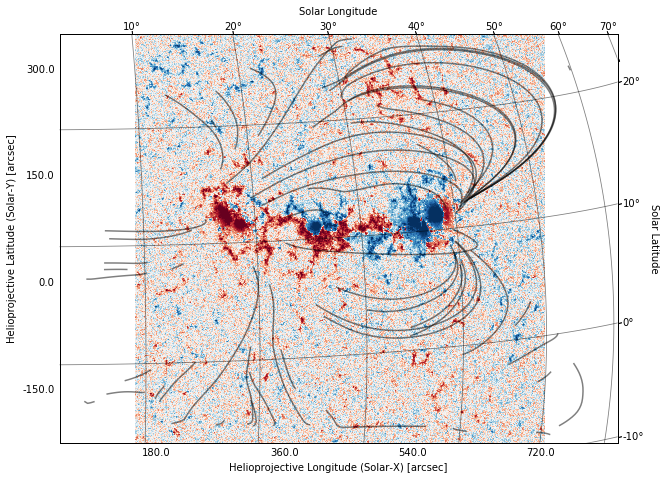

In [94]:
boundary_map = m_zoom#oblique_field.hmi_map
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111,projection=aia_m)
#im = aia_m.plot(axes=ax,title=False,norm=matplotlib.colors.LogNorm(vmin=50,vmax=5e3))
#aia_m.draw_grid(axes=ax,grid_spacing=10*u.deg,color='w')
ax = fig.gca(projection=boundary_map)
im = boundary_map.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
boundary_map.draw_grid(axes=ax,grid_spacing=10*u.deg,color='k')
ax.grid(alpha=0)
ar_center = boundary_map.center.transform_to(
    sunpy.coordinates.frames.Heliocentric(
        observer=boundary_map.observer_coordinate)).data
for stream in streams.streamlines[::]:
#    #ax.plot(oblique_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
#    #        oblique_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
#    #        alpha=0.5,color='r',transform=ax.get_transform('world'))
    stream = np.roll(np.array(stream),1,axis=1)
    loop_rot = rotation_y(-extrapolator.center.lat) @ rotation_z(extrapolator.center.lon) @ stream.T
    x_hcc,y_hcc,z_hcc = extrapolator._heeq_to_hcc(loop_rot[0,:],loop_rot[1,:],loop_rot[2,:])
    x_hcc = (x_hcc*u.cm).to(u.km) + ar_center.x
    y_hcc = (y_hcc*u.cm).to(u.km) + ar_center.y
    z_hcc = (z_hcc*u.cm).to(u.km) + ar_center.z
    ax.plot_coord((astropy.coordinates.SkyCoord(x=x_hcc,
                                                y=y_hcc,
                                                z=z_hcc,
                                                frame=sunpy.coordinates.frames.Heliocentric,
                                                observer=boundary_map.observer_coordinate)
                   .transform_to(boundary_map.coordinate_frame)),'k-',alpha=0.5)

## Coordinate Transform Sandbox

In [ ]:
los = boundary_map.observer_coordinate.transform_to(
    sunpy.coordinates.frames.Heliocentric(
        #observer=boundary_map.observer_coordinate
    )
)

In [ ]:
los

In [ ]:
sunpy.coordinates.transformations.hcc_to_hgs(los,boundary_map.coordinate_frame)